In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes.patch import PolygonPatch

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading and preparing data

```stack``` is the original stack as it is loaded from file<br>
```segchannel``` is the membrane channel only (needs to be taken out of loaded stack)<br>
```flowchannel``` is the myosin channel only<br>
```segchannel_smooth``` is the ```segchannel``` after gaussian smoothing<br>
(note: the less the better for the gradientimage)<br>
```gradientimage``` should be used for segmentation if some of the cell boundary (membrane) is barely visible<br>

In [2]:
#filename = '/Users/prakash/anaconda/envs/BobSegExtra/Data/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
filename = '/Users/prakash/Dropbox/2018-04-13_fromMark/MAX_mNG-mSc_04_MEDIUM_UNCOUPLED.tif'
#filename = '/Users/prakash/Dropbox/2018-04-13_fromMark/MAX_mNG-mSc_05_MEDIUM_COUPLED.tif'

stack = imread(filename)
segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]

sigma = [0.,2,2]
segchannel_smooth = gaussian(segchannel,sigma)
flowchannel_smooth = gaussian(flowchannel,[0.,1,1])

gradientimage = np.minimum(flowchannel_smooth/np.mean(flowchannel_smooth), np.ones_like(flowchannel_smooth))
gradientimage += segchannel_smooth/np.max(segchannel_smooth)
gx = np.gradient(gradientimage, 25, axis=2)
gy = np.gradient(gradientimage, 25, axis=1)
gx = np.abs(gx)
gy = np.abs(gy)
gradientimage = gx+gy                  # add x and y gradients
gradientimage /= np.max(gradientimage) # normalizes such that largest value is 1.0
gradientimage **= .5                   # emphasizes smaller gradient values
gradientimage = gaussian(gradientimage,sigma)

T = len(segchannel)  # number of time-points

print('Shape of stack:', stack.shape)
print('Shape of flow channel:', flowchannel.shape)

Shape of stack: (61, 2, 545, 833)
Shape of flow channel: (61, 545, 833)


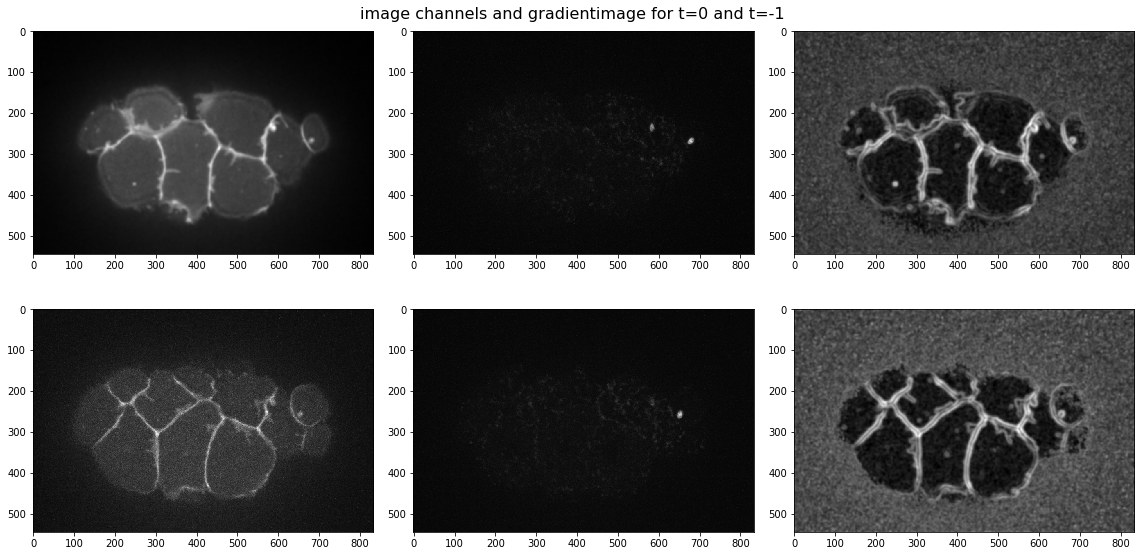

In [3]:
pylab.rcParams['figure.figsize'] = (16, 8)
fig = plt.figure()
fig.suptitle('image channels and gradientimage for t=0 and t=-1', fontsize=16)
ax = fig.add_subplot(231)
ax.imshow(segchannel_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(232)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(233)
ax.imshow(gradientimage[0], plt.get_cmap('gray'))
ax = fig.add_subplot(234)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(235)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(236)
ax.imshow(gradientimage[-1], plt.get_cmap('gray'))
fig.tight_layout()

# Cell segmentation

In [4]:
# defining min and max radius for cell segmentation
max_rs = ((segchannel[0].shape[1] / 6),
          (segchannel[0].shape[1] / 6))

min_rs = (10,10)
print (min_rs, max_rs)

(10, 10) (138.83333333333334, 138.83333333333334)


In [5]:
data = Data3d( gradientimage, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

In [6]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
data.add_object_at( cell_Ea, min_rs, max_rs, frame=0, seed=(520,225), segment_it=True )
data.track(cell_Ea, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ea" in frame 0 with seed coordinates [ 520.  225.]
      Optimum energy:  22.95779901974668
      Nodes in/out:  3962 3238
      Area:  20037.0
Added appearance for "Ea" in frame 1 with seed coordinates [ 520.  225.]
      Optimum energy:  24.466701459607382
      Nodes in/out:  3971 3229
      Area:  20133.5
    Updated center to [ 511.95833333  220.51388889]
Added appearance for "Ea" in frame 2 with seed coordinates [ 512.  221.]
      Optimum energy:  25.998814522005645
      Nodes in/out:  4090 3110
      Area:  21125.5
    Updated center to [ 507.25        216.61111111]
Added appearance for "Ea" in frame 3 with seed coordinates [ 507.  217.]
      Optimum energy:  24.96058289456702
      Nodes in/out:  4079 3121
      Area:  20759.5
    Updated center to [ 507.06944444  215.90277778]
Added appearance for "Ea" in frame 4 with seed coordinates [ 507.  216.]
      Optimum energy:  24.774622145595274
      Nodes in/out:  4027 3173
      Area:  20310.0
    Updated

      Optimum energy:  23.359027914232797
      Nodes in/out:  3798 3402
      Area:  18157.0
    Updated center to [ 506.23611111  190.36111111]
Added appearance for "Ea" in frame 40 with seed coordinates [ 506.  190.]
      Optimum energy:  23.544938156333846
      Nodes in/out:  3802 3398
      Area:  18304.5
    Updated center to [ 504.79166667  188.93055556]
Added appearance for "Ea" in frame 41 with seed coordinates [ 505.  189.]
      Optimum energy:  22.57441633481749
      Nodes in/out:  3670 3530
      Area:  17021.5
    Updated center to [ 507.04166667  189.95833333]
Added appearance for "Ea" in frame 42 with seed coordinates [ 507.  190.]
      Optimum energy:  22.517898698404483
      Nodes in/out:  3805 3395
      Area:  18179.5
    Updated center to [ 507.30555556  188.29166667]
Added appearance for "Ea" in frame 43 with seed coordinates [ 507.  188.]
      Optimum energy:  23.789359790939155
      Nodes in/out:  3526 3674
      Area:  16241.5
    Updated center to [ 505

In [7]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
data.add_object_at( cell_Ep, min_rs, max_rs, frame=0, seed=(620,275), segment_it=True )
data.track(cell_Ep, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ep" in frame 0 with seed coordinates [ 620.  275.]
      Optimum energy:  25.546052366808432
      Nodes in/out:  3281 3919
      Area:  14509.0
Added appearance for "Ep" in frame 1 with seed coordinates [ 620.  275.]
      Optimum energy:  26.298062084102387
      Nodes in/out:  3178 4022
      Area:  13819.0
    Updated center to [ 617.41666667  280.875     ]
Added appearance for "Ep" in frame 2 with seed coordinates [ 617.  281.]
      Optimum energy:  25.45587703390109
      Nodes in/out:  3263 3937
      Area:  14233.0
    Updated center to [ 618.22222222  284.26388889]
Added appearance for "Ep" in frame 3 with seed coordinates [ 618.  284.]
      Optimum energy:  25.662322488255626
      Nodes in/out:  3276 3924
      Area:  14495.5
    Updated center to [ 617.66666667  287.79166667]
Added appearance for "Ep" in frame 4 with seed coordinates [ 618.  288.]
      Optimum energy:  25.321993079290348
      Nodes in/out:  3269 3931
      Area:  14318.0
    Update

      Optimum energy:  26.088949373455684
      Nodes in/out:  2602 4598
      Area:  9762.0
    Updated center to [ 607.63888889  267.40277778]
Added appearance for "Ep" in frame 39 with seed coordinates [ 608.  267.]
      Optimum energy:  27.74568886947456
      Nodes in/out:  2607 4593
      Area:  9718.0
    Updated center to [ 606.72222222  265.59722222]
Added appearance for "Ep" in frame 40 with seed coordinates [ 607.  266.]
      Optimum energy:  25.328605023253573
      Nodes in/out:  2723 4477
      Area:  10831.5
    Updated center to [ 609.26388889  267.65277778]
Added appearance for "Ep" in frame 41 with seed coordinates [ 609.  268.]
      Optimum energy:  25.046192736711955
      Nodes in/out:  2790 4410
      Area:  11384.0
    Updated center to [ 610.34722222  270.08333333]
Added appearance for "Ep" in frame 42 with seed coordinates [ 610.  270.]
      Optimum energy:  25.668710494822882
      Nodes in/out:  2828 4372
      Area:  11473.0
    Updated center to [ 610.7

In [8]:
surface_coords_Ea = data.segment2dt( cell_Ea, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  1486.925597114033
      Area:  20177.5
Results for frame 1:
      Optimum energy:  1486.925597114033
      Area:  20344.5
Results for frame 2:
      Optimum energy:  1486.925597114033
      Area:  20370.0
Results for frame 3:
      Optimum energy:  1486.925597114033
      Area:  20128.0
Results for frame 4:
      Optimum energy:  1486.925597114033
      Area:  20077.5
Results for frame 5:
      Optimum energy:  1486.925597114033
      Area:  20166.0
Results for frame 6:
      Optimum energy:  1486.925597114033
      Area:  20172.0
Results for frame 7:
      Optimum energy:  1486.925597114033
      Area:  19983.0
Results for frame 8:
      Optimum energy:  1486.925597114033
      Area:  19759.5
Results for frame 9:
      Optimum energy:  1486.925597114033
      Area:  19647.0
Results for frame 10:
      Optimum energy:  1486.925597114033
      Area:  19811.5
Results for frame 11:
      Optimum energy:  1486.925597114033
      Area:  19824.0
Re

In [9]:
surface_coords_Ep = data.segment2dt( cell_Ep, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  1563.3831534416274
      Area:  14803.0
Results for frame 1:
      Optimum energy:  1563.3831534416274
      Area:  14538.5
Results for frame 2:
      Optimum energy:  1563.3831534416274
      Area:  14546.5
Results for frame 3:
      Optimum energy:  1563.3831534416274
      Area:  14766.0
Results for frame 4:
      Optimum energy:  1563.3831534416274
      Area:  15039.5
Results for frame 5:
      Optimum energy:  1563.3831534416274
      Area:  15674.5
Results for frame 6:
      Optimum energy:  1563.3831534416274
      Area:  15860.0
Results for frame 7:
      Optimum energy:  1563.3831534416274
      Area:  16224.5
Results for frame 8:
      Optimum energy:  1563.3831534416274
      Area:  16049.5
Results for frame 9:
      Optimum energy:  1563.3831534416274
      Area:  15830.0
Results for frame 10:
      Optimum energy:  1563.3831534416274
      Area:  15773.5
Results for frame 11:
      Optimum energy:  1563.3831534416274
      Area:

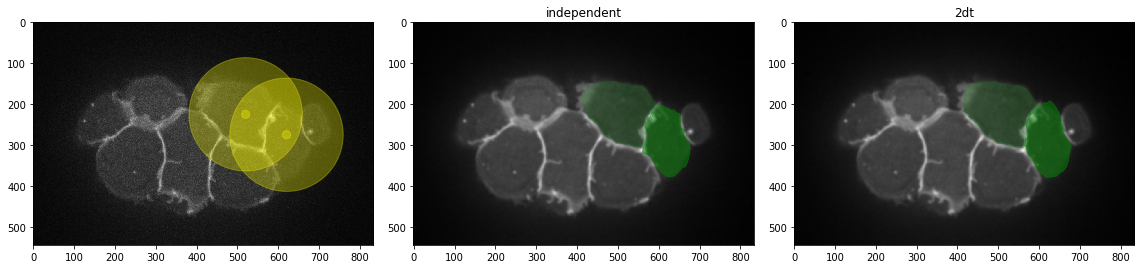

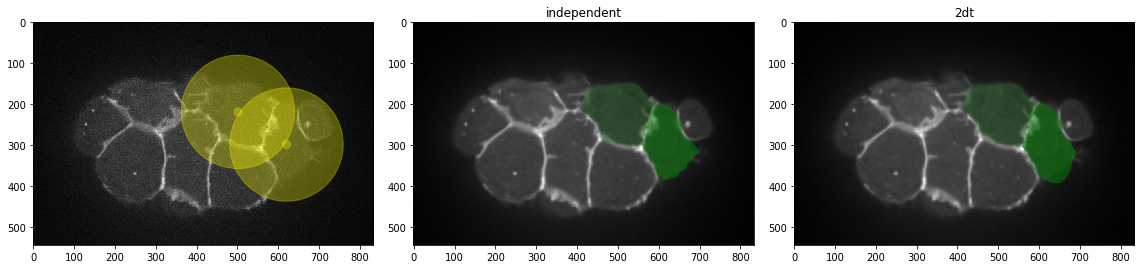

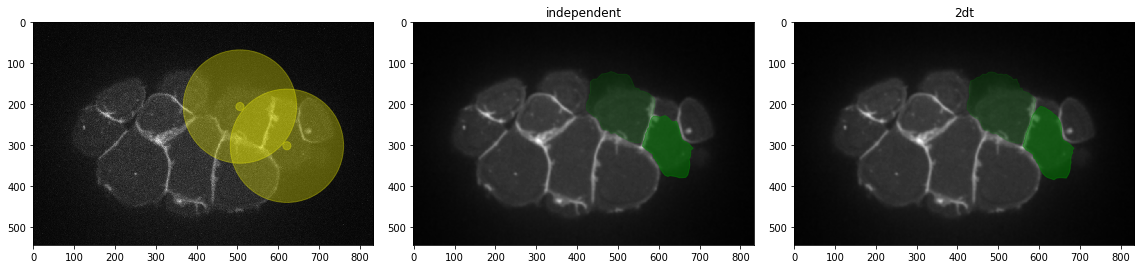

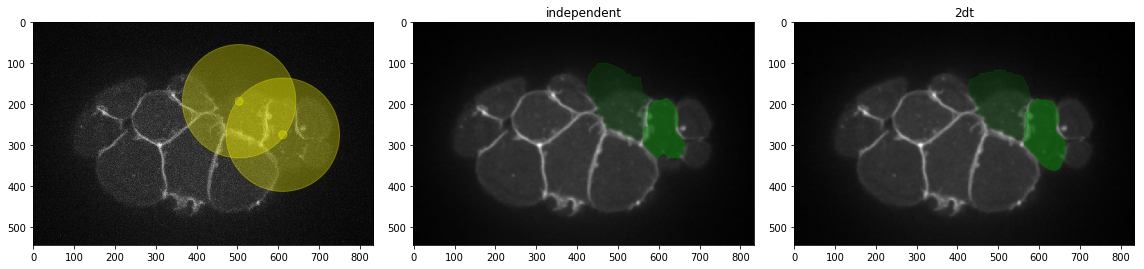

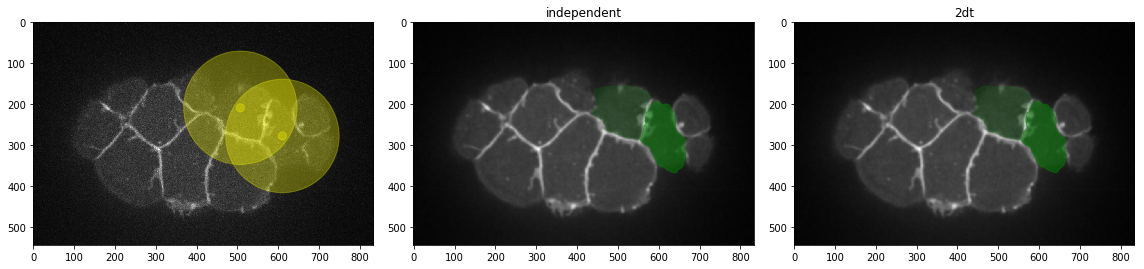

In [10]:
pylab.rcParams['figure.figsize'] = (16, 10)
for frame in range(1,len(data.images),int(len(data.images)/5)):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax, segchannel )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax, segchannel_smooth )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax, segchannel_smooth )
    fig.tight_layout()

# Flow computation

In [11]:
flows = bsu.compute_flow( flowchannel )
flow_x, flow_y = bsu.split_flow_components( flows )

............................................................. ...done!


In [12]:
avg_flow_x = bsu.flow_average(flow_x, 5)
avg_flow_y = bsu.flow_average(flow_y, 5)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

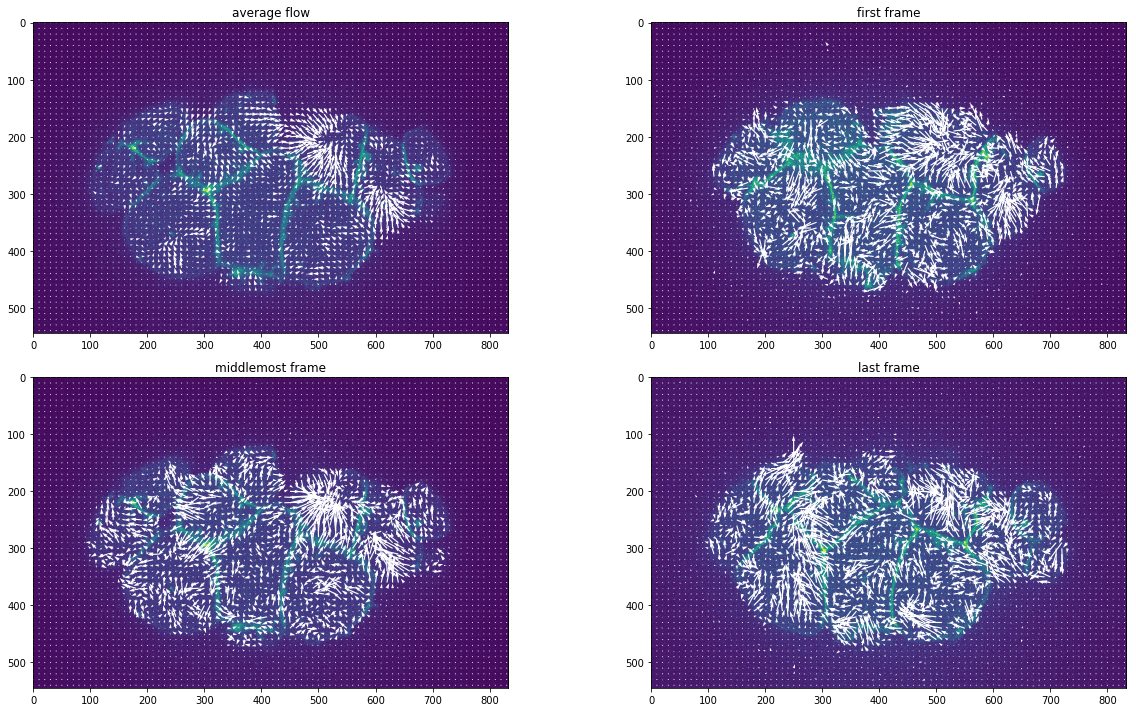

In [13]:
pylab.rcParams['figure.figsize'] = (18, 10)
fig = plt.figure()

y,x = np.mgrid[0:shape(segchannel)[1]:1, 0:shape(segchannel)[2]:1]
skip = (slice(None, None, 10), slice(None, None, 10))

ax = plt.subplot(221)
ax.set_title('average flow')
ax.imshow(segchannel[int(len(flowchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],total_avg_flow_x[skip],-total_avg_flow_y[skip], color='w', scale=50)

ax = plt.subplot(222)
ax.set_title('first frame')
ax.imshow(segchannel[0])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[0][skip],-avg_flow_y[0][skip], color='w', scale=50)

ax = plt.subplot(223)
ax.set_title('middlemost frame')
ax.imshow(segchannel[int(len(flowchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[int(len(flowchannel)/2)][skip],-avg_flow_y[int(len(flowchannel)/2)][skip], color='w', scale=50)

ax = plt.subplot(224)
ax.set_title('last frame')
ax.imshow(segchannel[-1])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[-1][skip],-avg_flow_y[-1][skip], color='w', scale=50)

fig.tight_layout()
fig.savefig('test.pdf',dpi=300)

# Flow data crunching...

In [14]:
annulus_outer_factor = .85
annulus_inner_factor = .6

In [15]:
membrane_polygones_per_object = []
annulus_outer_polygones_per_object = []
annulus_middle_polygones_per_object = []
annulus_inner_polygones_per_object = []
for obj in objects:
    membrane_polygones = []
    annulus_outer_polygones = []
    annulus_middle_polygones = []
    annulus_inner_polygones = []
    for t in range(T):
        membrane_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,1.0) )
        annulus_outer_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_outer_factor) )
        annulus_middle_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,(annulus_outer_factor+annulus_inner_factor)/2) )
        annulus_inner_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_inner_factor) )
    membrane_polygones_per_object.append(membrane_polygones)
    annulus_outer_polygones_per_object.append(annulus_outer_polygones)
    annulus_middle_polygones_per_object.append(annulus_middle_polygones)
    annulus_inner_polygones_per_object.append(annulus_inner_polygones)

In [16]:
def get_annulus_bresenham_lines(inner_polygone, outer_polygone):
    annulus_bresenham_lines = []
    for i in range(len(inner_polygone)):
        points = bham.bresenhamline( np.array([inner_polygone[i]]),np.array([outer_polygone[i]]) )
        annulus_bresenham_lines.append(points)
    return annulus_bresenham_lines

In [17]:
annulus_bresenham_lines_per_frame_per_object = []
for obj in objects:
    annulus_bresenham_lines_per_frame = []
    for t in range(T):
        annulus_bresenham_lines = get_annulus_bresenham_lines( annulus_inner_polygones_per_object[obj][t], annulus_outer_polygones_per_object[obj][t] )
        annulus_bresenham_lines_per_frame.append( annulus_bresenham_lines )
    annulus_bresenham_lines_per_frame_per_object.append( annulus_bresenham_lines_per_frame )

### compute membrane movement vectors

In [18]:
membrane_movement_vectors_per_frame_per_object = []
for obj in objects:
    membrane_movement_vectors_per_frame = []
    for t in range(T-1):
        membrane_movement_vectors = []
        poly_t1 = membrane_polygones_per_object[obj][t]
        poly_t2 = membrane_polygones_per_object[obj][t+1]
        for i in range(len(poly_t1)):
            p1 = [poly_t1[i][0] , poly_t1[i][1]]
            p2 = [poly_t2[i][0] , poly_t2[i][1]]
            membrane_movement_vectors.append( [p2[0]-p1[0] , p2[1]-p1[1]] )
        membrane_movement_vectors_per_frame.append( membrane_movement_vectors )
    membrane_movement_vectors_per_frame_per_object.append( membrane_movement_vectors_per_frame )

### compute averaged flow vectors

In [19]:
annulus_avg_flow_vectors_per_frame_per_object = []
for obj in objects:
    annulus_avg_flow_vectors_per_frame = []
    for t in range(T):
        annulus_avg_flow_vectors = []
        lines = annulus_bresenham_lines_per_frame_per_object[obj][t]
        for l, line in enumerate(lines):
            sum_x = 0.0
            sum_y = 0.0
            for point in line:
                sum_x += avg_flow_x[t,point[1],point[0]]
                sum_y += avg_flow_y[t,point[1],point[0]]
            avg_x = sum_x / len(line)
            avg_y = sum_y / len(line)
            annulus_avg_flow_vectors.append([avg_x,avg_y])
        annulus_avg_flow_vectors_per_frame.append(annulus_avg_flow_vectors)
    annulus_avg_flow_vectors_per_frame_per_object.append( annulus_avg_flow_vectors_per_frame )

### compute projected vector lengths

In [20]:
column_vectors = data.netsurfs[0][0].col_vectors # they are normalized to length 1

In [21]:
projected_avg_flows_per_frame_per_object = []
projected_mem_vecs_per_frame_per_object = []
for obj in objects:
    projected_avg_flows_per_frame = []
    projected_mem_vecs_per_frame = []
    for t in range(T-1):
        projected_avg_flows = []
        projected_mem_vecs = []
        for i in range(len(column_vectors)):
            projected_avg_flows.append( bsu.get_projected_length(annulus_avg_flow_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
            projected_mem_vecs.append( bsu.get_projected_length(membrane_movement_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
        projected_avg_flows_per_frame.append( projected_avg_flows )
        projected_mem_vecs_per_frame.append( projected_mem_vecs )
    projected_avg_flows_per_frame_per_object.append( projected_avg_flows_per_frame )
    projected_mem_vecs_per_frame_per_object.append( projected_mem_vecs_per_frame )

### compute frame averages and correlations for lineplots

In [22]:
avg_membrane_contraction_per_frame_per_object = []
avg_center_flow_per_frame_per_object = []
correlation_per_frame_per_object = []
for obj in objects:
    avg_membrane_contraction_per_frame = []
    avg_center_flow_per_frame = []
    correlation_per_frame = []
    for t in range(T-1):
        memveclengths=projected_mem_vecs_per_frame_per_object[obj][t]
        flowveclengths=projected_avg_flows_per_frame_per_object[obj][t]
        
        avg_membrane_contraction_per_frame.append( np.mean(memveclengths) )
        avg_center_flow_per_frame.append( np.mean( flowveclengths) )
        correlation_per_frame.append( pearsonr(memveclengths, flowveclengths)[0] )
        
    avg_membrane_contraction_per_frame_per_object.append( avg_membrane_contraction_per_frame )
    avg_center_flow_per_frame_per_object.append( avg_center_flow_per_frame )
    correlation_per_frame_per_object.append( correlation_per_frame )

### initialize imaginary myosins

In [23]:
initialization_time = 0

In [24]:
initial_myo_pos_per_object = []
for obj in objects:
    initial_myo_pos_list = []
    for i in range(len(column_vectors)):
        initial_myo_pos_list.append(annulus_bresenham_lines_per_frame_per_object[obj][initialization_time][i])
    initial_myo_pos = [item for sublist in initial_myo_pos_list for item in sublist]
    initial_myo_pos_per_object.append(initial_myo_pos)
# initial_myo_pos_per_object = []
# for obj in objects:
#     initial_myo_pos_per_object.append(annulus_outer_polygones_per_object[obj][initialization_time])

### Tracking imaginary myosins over time

In [25]:
position_imaginary_myosins_per_frame_per_object = []
for obj in objects:
    position_imaginary_myosins_per_frame = []
    temporary_list = list(initial_myo_pos_per_object[obj])
    for t in range(initialization_time, T, 1):
        position_imaginary_myosin = []
        for myosin_count in range(len(temporary_list)):
            new_myosin_position = bsu.update_pos(temporary_list[myosin_count],t, avg_flow_x, avg_flow_y)
            position_imaginary_myosin.append(new_myosin_position)
            temporary_list[myosin_count] = new_myosin_position
        position_imaginary_myosins_per_frame.append(position_imaginary_myosin)
        
    position_imaginary_myosins_per_frame_per_object.append(position_imaginary_myosins_per_frame)

### Number crunching for plots

In [26]:
cumulative_myosin_dist_per_frame_per_object = []
for obj in objects:
    cumulative_myosin_dist_per_frame = []
    for frame in range(0,len(segchannel)-initialization_time-1,1):
        myosin_dist_from_center = 0

        for i in range(len(initial_myo_pos_per_object[obj])):
            dist2 = bsu.euclid_dist(position_imaginary_myosins_per_frame_per_object[obj][frame][i], data.object_seedpoints[obj][frame+1])
            myosin_dist_from_center = dist2 + myosin_dist_from_center

        cumulative_myosin_dist_per_frame.append(myosin_dist_from_center)   
    cumulative_myosin_dist_per_frame_per_object.append(cumulative_myosin_dist_per_frame)

In [27]:
cumulative_membrane_dist_per_frame_per_object = []
for obj in objects:
    cumulative_membrane_dist_per_frame = []
    for frame in range(1,len(segchannel)-initialization_time,1):
        membrane_dist_from_center = 0
        for j in range(len(column_vectors)):
            dist1 = bsu.euclid_dist(membrane_polygones_per_object[obj][frame][j], data.object_seedpoints[obj][frame])
            membrane_dist_from_center = membrane_dist_from_center+dist1
        cumulative_membrane_dist_per_frame.append(membrane_dist_from_center)
    cumulative_membrane_dist_per_frame_per_object.append(cumulative_membrane_dist_per_frame)

In [28]:
#Number crunching for plots
flow_movement_factor_list_per_object = []
membrane_movement_factor_list_per_object = []
for obj in objects:
    flow_movement_factor_list = []
    membrane_movement_factor_list =[]
    for i in range(len(cumulative_myosin_dist_per_frame_per_object[obj])-1):
        flow_movement_factor = cumulative_myosin_dist_per_frame_per_object[obj][i+1]/cumulative_myosin_dist_per_frame_per_object[obj][i]
        flow_movement_factor_list.append(flow_movement_factor)
        membrane_movement_factor = cumulative_membrane_dist_per_frame_per_object[obj][i+1]/cumulative_membrane_dist_per_frame_per_object[obj][i]
        membrane_movement_factor_list.append(membrane_movement_factor)
    flow_movement_factor_list_per_object.append(flow_movement_factor_list)
    membrane_movement_factor_list_per_object.append(membrane_movement_factor_list)

In [29]:
print(len(membrane_movement_factor_list_per_object[0]))

59


In [30]:
#Plotting flow ratio and membrane ratio computed above
t = np.arange(initialization_time, len(membrane_movement_factor_list_per_object[0]), 1.)
plt.plot(t, flow_movement_factor_list_per_object[0], 'r--',t, membrane_movement_factor_list_per_object[0], 'g--')
plt.plot(t, np.ones_like(t),'k-')
plt.show()

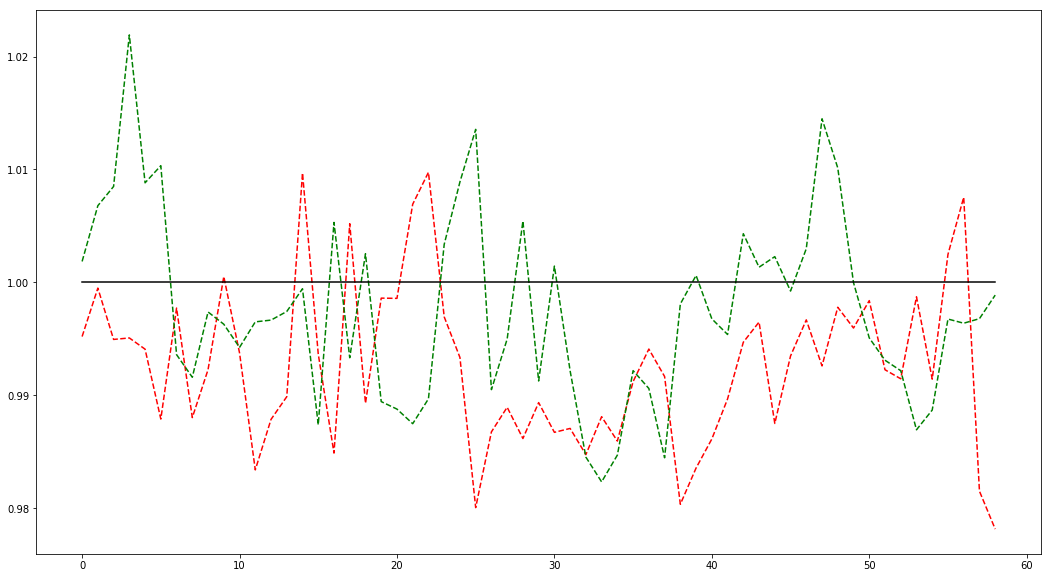

In [31]:
#Plotting flow ratio and membrane ratio computed above
t = np.arange(initialization_time, len(membrane_movement_factor_list_per_object[1]), 1.)
plt.plot(t, flow_movement_factor_list_per_object[1], 'r--',t, membrane_movement_factor_list_per_object[1], 'g--')
plt.plot(t, np.ones_like(t),'k-')
plt.show()

In [32]:
flow_movement_factor_list_per_object[0] = [list(x) for x in flow_movement_factor_list_per_object[0]]
flattened_flow_movement_factor_list0 = [val for sublist in flow_movement_factor_list_per_object[0] for val in sublist]

In [33]:
flow_movement_factor_list_per_object[1] = [list(x) for x in flow_movement_factor_list_per_object[1]]
flattened_flow_movement_factor_list1 = [val for sublist in flow_movement_factor_list_per_object[1] for val in sublist]

In [42]:
corr0 = []
length = 20
for start in range(0,len(flow_movement_factor_list_per_object[0])-length,1):
    c0,p0 = pearsonr(flattened_flow_movement_factor_list0[start:start+length], membrane_movement_factor_list_per_object[0][start:start+length])
    print('start: ', start, '; ','till ',start+length, c0, p0)
    corr0.append(c0)

start:  0 ;  till  20 0.322262598467 0.165837404728
start:  1 ;  till  21 0.328087330118 0.157884131024
start:  2 ;  till  22 0.403389401235 0.0777850982511
start:  3 ;  till  23 0.454892564527 0.0438821082621
start:  4 ;  till  24 0.476229141669 0.0337809190746
start:  5 ;  till  25 0.492265869785 0.0274631413841
start:  6 ;  till  26 0.468199596418 0.0373432961913
start:  7 ;  till  27 0.230314760268 0.32862085215
start:  8 ;  till  28 0.242726861895 0.302476741284
start:  9 ;  till  29 0.272670196163 0.244786618224
start:  10 ;  till  30 0.239942031556 0.308229277236
start:  11 ;  till  31 0.272863086301 0.244439691166
start:  12 ;  till  32 0.241368042867 0.305275405066
start:  13 ;  till  33 0.264998434248 0.258840945055
start:  14 ;  till  34 0.351244176519 0.128880390656
start:  15 ;  till  35 0.369979065503 0.108353765027
start:  16 ;  till  36 0.392173218627 0.0872259432793
start:  17 ;  till  37 0.404267881604 0.0770791681315
start:  18 ;  till  38 0.488226774408 0.0289586894

In [43]:
corr1 = []
length = 20
for start in range(0,len(flow_movement_factor_list_per_object[1])-length,1):
    c1,p1 = pearsonr(flattened_flow_movement_factor_list1[start:start+length], membrane_movement_factor_list_per_object[1][start:start+length])
    print('start: ', start, '; ','till ',start+length, c1, p1)
    corr1.append(c1)

start:  0 ;  till  20 -0.097730323007 0.681875839624
start:  1 ;  till  21 -0.138286642395 0.560956775575
start:  2 ;  till  22 -0.275587768177 0.239572843082
start:  3 ;  till  23 -0.344127923035 0.137356129551
start:  4 ;  till  24 -0.425500455708 0.0614277698794
start:  5 ;  till  25 -0.433519986636 0.0561890275467
start:  6 ;  till  26 -0.518591759853 0.0191442317062
start:  7 ;  till  27 -0.453946326342 0.04437862891
start:  8 ;  till  28 -0.480485227144 0.0320034576619
start:  9 ;  till  29 -0.50874034009 0.0219816081544
start:  10 ;  till  30 -0.481276085497 0.0316813914395
start:  11 ;  till  31 -0.494011624551 0.0268358794688
start:  12 ;  till  32 -0.478906933896 0.0326538496554
start:  13 ;  till  33 -0.367678701702 0.110737820824
start:  14 ;  till  34 -0.291122259855 0.213022601169
start:  15 ;  till  35 -0.309482116236 0.184242199247
start:  16 ;  till  36 -0.304105356413 0.192382277027
start:  17 ;  till  37 -0.267658062882 0.253912006192
start:  18 ;  till  38 -0.268413

Text(0,0.5,'correlation')

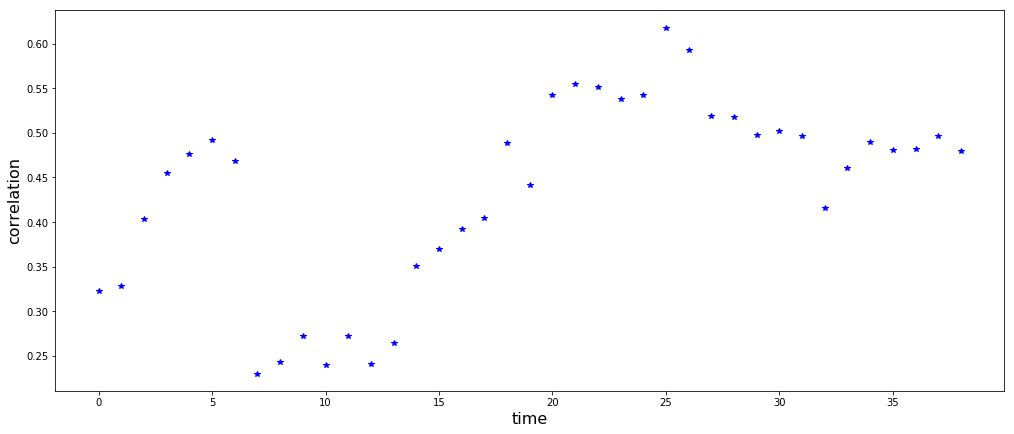

In [44]:
pyplot.plot(corr0, 'b*')
plt.xlabel('time', fontsize = 16)
plt.ylabel('correlation', fontsize = 16)

Text(0,0.5,'correlation')

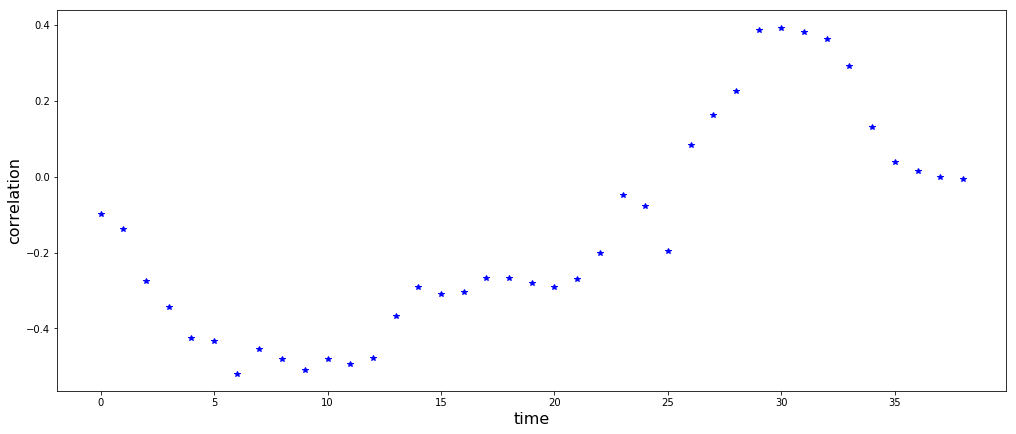

In [45]:
pyplot.plot(corr1, 'b*')
plt.xlabel('time', fontsize = 16)
plt.ylabel('correlation', fontsize = 16)

In [38]:
def plot_coords(ax, poly, c, style='.-', alpha=.5):
    x, y = poly.xy
    ax.plot(x, y, style, color=c, alpha=alpha, zorder=1)

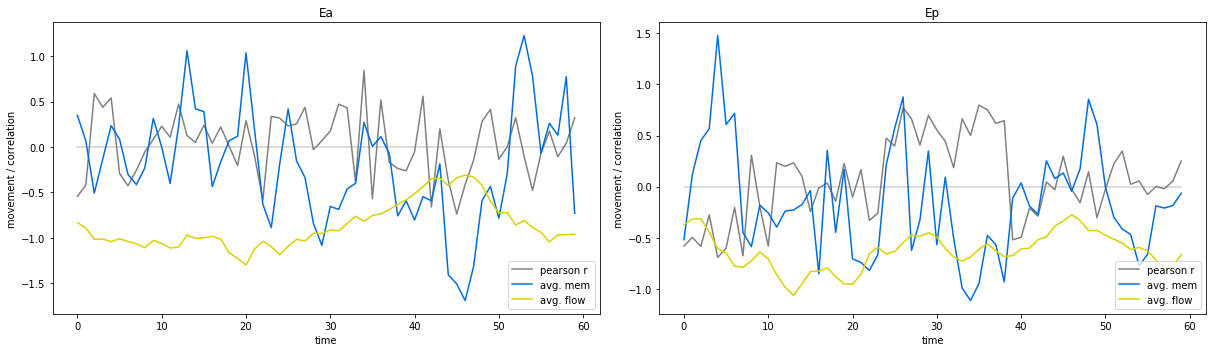

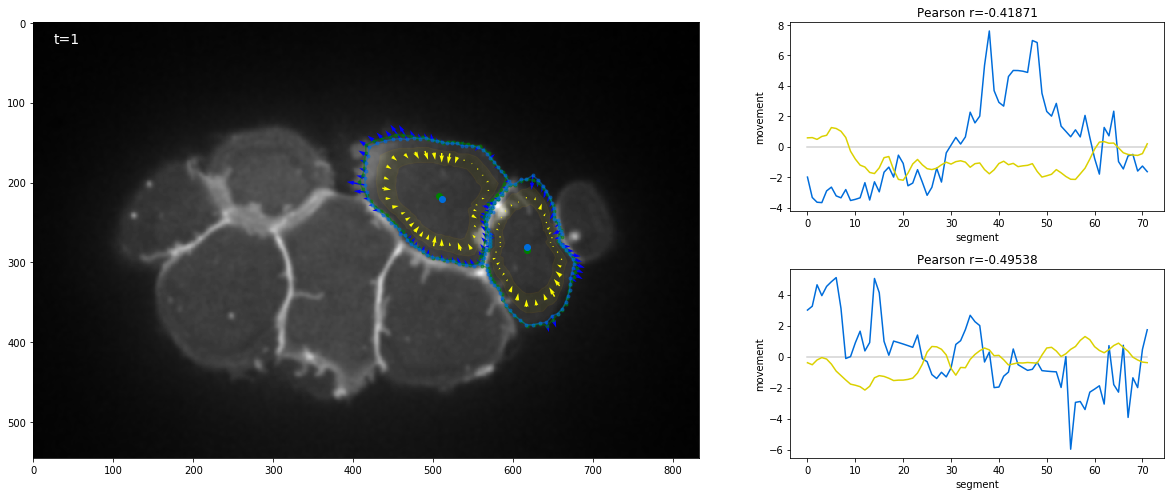

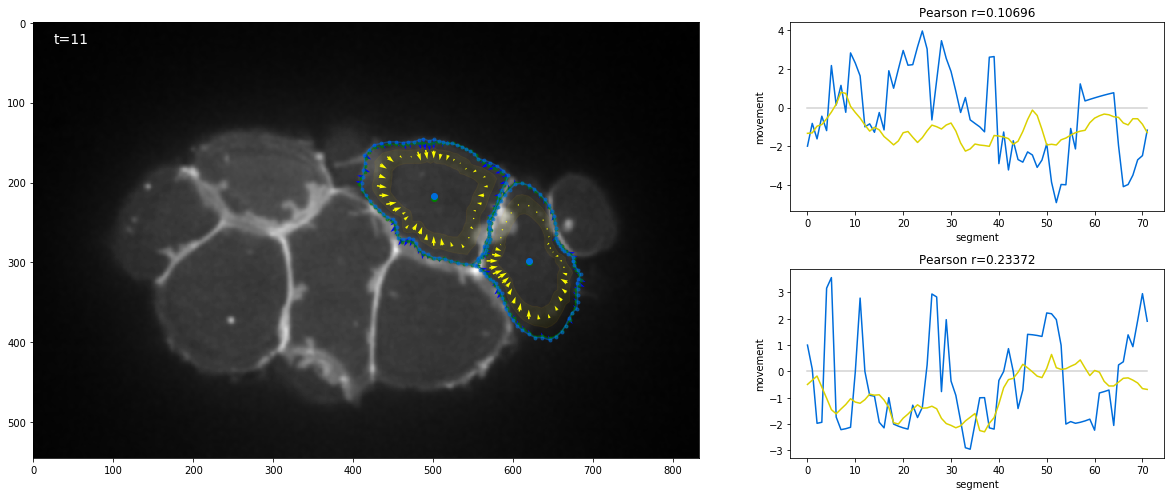

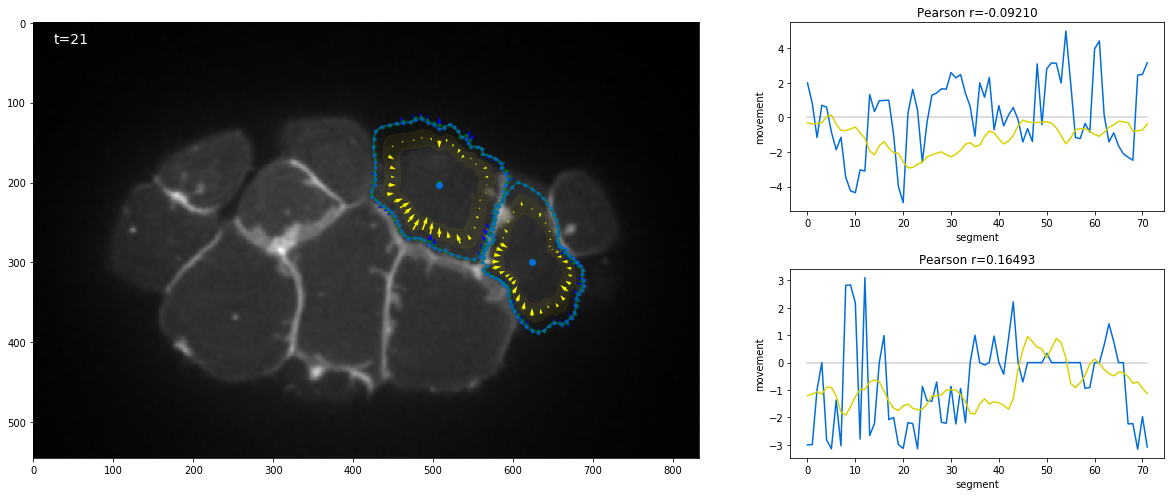

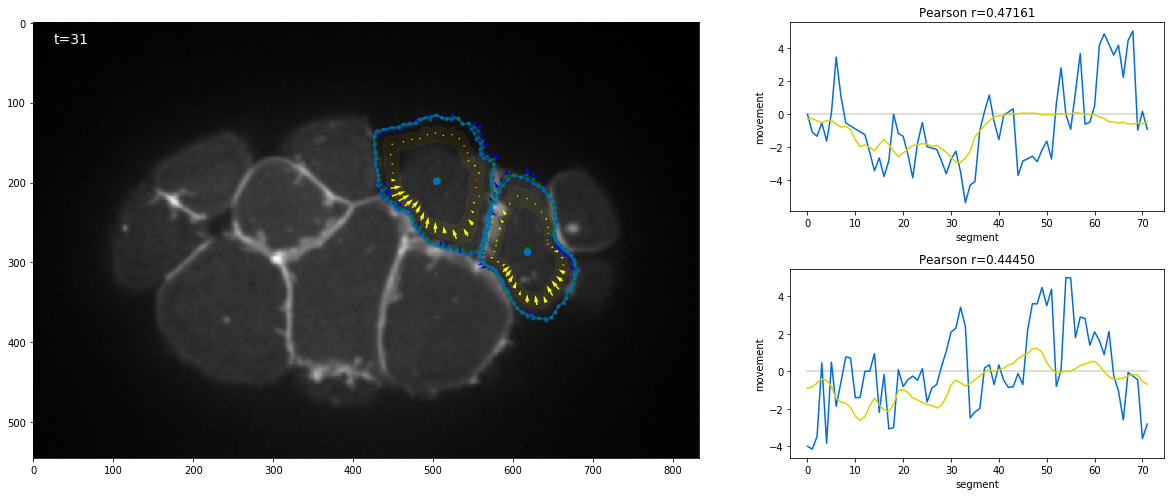

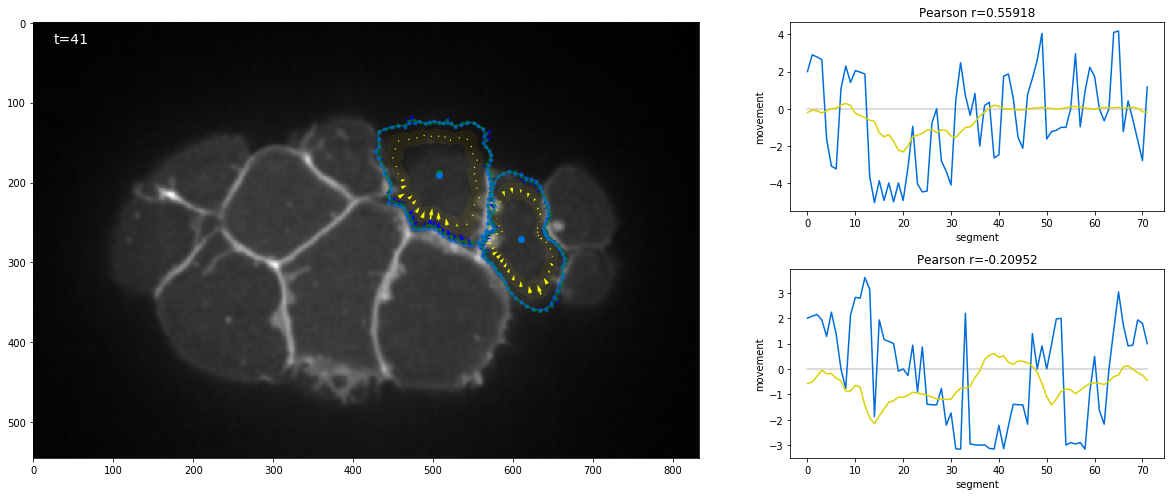

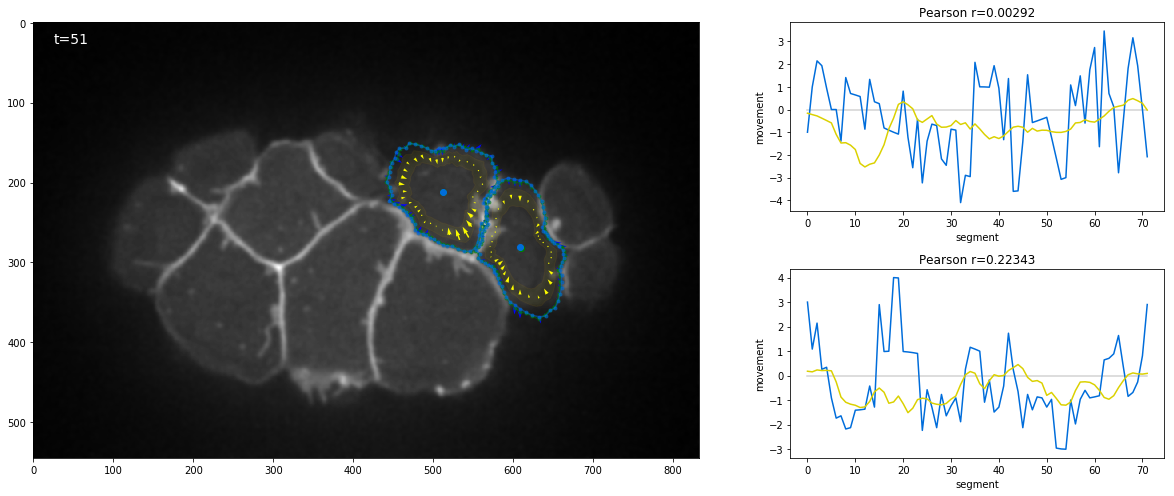

In [39]:
pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()
ax = plt.subplot(121)
ax.set_title(data.object_names[0])
ax.set_xlabel('time')
ax.set_ylabel('movement / correlation')
ax.plot(np.zeros_like(correlation_per_frame_per_object[0]), color='lightgray')
ax.plot(correlation_per_frame_per_object[0], color='gray', label='pearson r')
ax.plot(avg_membrane_contraction_per_frame_per_object[0], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[0], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
ax = plt.subplot(122)
ax.set_title(data.object_names[1])
ax.set_xlabel('time')
ax.set_ylabel('movement / correlation')
ax.plot(np.zeros_like(correlation_per_frame_per_object[1]), color='lightgray')
ax.plot(correlation_per_frame_per_object[1], color='gray', label='pearson r')
ax.plot(avg_membrane_contraction_per_frame_per_object[1], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[1], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
fig.tight_layout()

pylab.rcParams['figure.figsize'] = (17, 7)
offset = 0
stepsize = 2
show_projected = True

for t in range(1,len(flowchannel),10):
    fig = plt.figure()
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot(233)
    ax3 = plt.subplot(236)

    ax.imshow(segchannel_smooth[t], plt.get_cmap('gray'))
    ax.text(25, 25, 't=%d'%t, fontsize=14, color='w')

    for obj in objects:
        # center points
        ax.plot(data.object_seedpoints[obj][t+1][0],data.object_seedpoints[obj][t+1][1], 'o', color='green')
        ax.plot(data.object_seedpoints[obj][t][0],data.object_seedpoints[obj][t][1], 'o', color='#%02x%02x%02x'%(0,109,219))
        
        # polygones (membrane and annulus)
        poly_membrane = geometry.Polygon(membrane_polygones_per_object[obj][t])
        poly_membrane_t2 = geometry.Polygon(membrane_polygones_per_object[obj][t+1])
        poly_annulus = geometry.Polygon(annulus_outer_polygones_per_object[obj][t], [annulus_inner_polygones_per_object[obj][t][::-1]])
        poly_annulus_middle = geometry.Polygon(annulus_middle_polygones_per_object[obj][t])

        plot_coords( ax, poly_membrane_t2.exterior, 'green', alpha=.5 )
        plot_coords( ax, poly_membrane.exterior, '#%02x%02x%02x'%(0,109,219) )

        patch_annulus = PolygonPatch(poly_annulus, facecolor='#%02x%02x%02x'%(219,209,0), edgecolor='orange', alpha=0.0625, zorder=2)
        ax.add_patch(patch_annulus)

        # membrane quivers
        mem_base_x = [p[0] for p in membrane_polygones_per_object[obj][t]]
        mem_base_y = [p[1] for p in membrane_polygones_per_object[obj][t]]
        if (show_projected):
            mem_vec = [column_vectors[i]*projected_mem_vecs_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            mem_vec_x = [v[0] for v in mem_vec]
            mem_vec_y = [-v[1] for v in mem_vec]
        else:
            mem_vec_x = [v[0] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
            mem_vec_y = [-v[1] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
        ax.quiver(mem_base_x, 
                  mem_base_y, 
                  mem_vec_x, 
                  mem_vec_y, 
                  width=0.0022, scale=flowchannel.shape[1]/2., color='blue')
        
        # flow quivers
        flow_base_x = [p[0] for p in annulus_middle_polygones_per_object[obj][t]]
        flow_base_y = [p[1] for p in annulus_middle_polygones_per_object[obj][t]]
        if (show_projected):
            flow_vec = [column_vectors[i]*projected_avg_flows_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            flow_vec_x = [v[0] for v in flow_vec]
            flow_vec_y = [-v[1] for v in flow_vec]
        else:
            flow_vec_x = [v[0] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
            flow_vec_y = [-v[1] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
        ax.quiver(flow_base_x[offset::stepsize], 
                  flow_base_y[offset::stepsize], 
                  flow_vec_x[offset::stepsize], 
                  flow_vec_y[offset::stepsize], 
                  pivot='mid', width=0.0022, scale=flowchannel.shape[1]/4., color='yellow')
        
    # LINEPLOT
    # ========
    ax2.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[0][t])
    ax2.set_xlabel('segment')
    ax2.set_ylabel('movement')
    ax2.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[0][t]), color='lightgray')
    ax2.plot(projected_mem_vecs_per_frame_per_object[0][t], color='#%02x%02x%02x'%(0,109,219))
    ax2.plot(projected_avg_flows_per_frame_per_object[0][t], color='#%02x%02x%02x'%(219,209,0))

    ax3.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[1][t])
    ax3.set_xlabel('segment')
    ax3.set_ylabel('movement')
    ax3.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[1][t]), color='lightgray')
    ax3.plot(projected_mem_vecs_per_frame_per_object[1][t], color='#%02x%02x%02x'%(0,109,219))
    ax3.plot(projected_avg_flows_per_frame_per_object[1][t], color='#%02x%02x%02x'%(219,209,0))

    fig.tight_layout()